# TrumpTwitterArchive Project & Introduction

Trump's use of Twitter for propaganda, promotion, and communication is unusual for the Presidency.  

    "David S. Ferriero informed two Democratic senators last week that the Trump tweets are being preserved for posterity, so future generations can revel in the president's peculiar and unprecedented use of Twitter as an art form and governing tool." -source theVerge

  The trumptwitterarchive is a collection of his every tweet, retweet, and favorite, and this project plans to load and predict engagement levels based on text, hastags, sentiment, and other feature columns.  Analysis on data will start after Trump's acceptance as the republican nominee at National Republican Convention on July 18, 2017.

**Hypothesis and Assumptions:**
    - Build a model that predicts the level of engagement for the President's tweets
    - Target Engagement (y), which is defined as the combination of favorite_count + retweet_count
    - Feature Columns: ['source', 'text', 'created_at', 'is_retweet']
    - Additional Feature Columns from Text:
      Create a sentiment score on Text.  Does negative sentiment increase engagement?
      Create Dummy variables for commonly used hashtags, which ones increase engagement?
      
      
      
**Table of Contents**
    1. Import & Review Data
    2. Prepare Data for Analysis
    3. Natural Language Processing - Sentiment Analysis
    4. Analysis and Visualizations
    5. Linear Regression
    6. Conclusion

# Import and Review Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import cross_val_score


plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
file = './data/trumptweets_all.csv'


In [4]:
# reading in csv file, setting the 'created_at' column as the index

trumptweets = pd.read_csv(file, encoding = 'latin1',
                          index_col='created_at')

In [5]:
# setting index of dates to datetime() format

trumptweets.index = pd.to_datetime(trumptweets.index)

In [6]:
# Only analyzing data since the 2016 Republican National Convention on 7/18/2016

trumptweets = trumptweets.loc[trumptweets.index > '2016-7-18 00:00:00', :]

In [7]:
# Review size and shape of the data set

trumptweets.shape

(4675, 6)

In [8]:
trumptweets.columns

Index(['source', 'text', 'retweet_count', 'favorite_count', 'is_retweet',
       'id_str'],
      dtype='object')

# Prepare Data for Analysis

In [9]:
# Convert Source column to dummy variables

#map source twitter for the 19 source values into integers

trumptweets.loc[:, 'source_num'] = trumptweets.loc[:,'source'].map({'Twitter for iPhone':0, 
                                                                    'Twitter for Android':1, 
                                                                    'Twitter Web Client':2, 
                                                                    'Media Studio':3, 
                                                                    'Twitter Ads':4, 
                                                                    'Twitter for iPad':5, 
                                                                    'TweetDeck':6, 
                                                                    'Periscope':7, 
                                                                    })

In [10]:
#Convert Source_num to dummy variables.  Dropping Twitter for iPhone where src = 0 for the regression model

dummy_trumptweets = pd.get_dummies(trumptweets, columns=['source_num']).drop('source_num_0', axis=1)

In [11]:
# Rename Dummy source_num columns

dummy_trumptweets.rename(columns={'source_num_1': 'src_android',
                                  'source_num_2': 'src_webclient',
                                  'source_num_3': 'src_mediastudio',
                                  'source_num_4': 'src_twitterads',
                                  'source_num_5': 'src_ipad',
                                  'source_num_6': 'src_tweetdeck',
                                  'source_num_7': 'src_periscope'},
                                  inplace=True)

In [12]:
#Create new column, engagement, that sums retweet and favorite counts.  This will become my target y

dummy_trumptweets.loc[:, 'engagement'] = (dummy_trumptweets.loc[:, 'retweet_count'] +
                                          dummy_trumptweets.loc[:, 'favorite_count'])

In [13]:
#add new column for HOUR when the tweet occurred

dummy_trumptweets.loc[:, 'tweet_hour'] = dummy_trumptweets.index.hour

In [14]:
# Convert hours to morning, afternoon, evening, latenight dummy variables.  Timestamp column is in GMT, so converting daytime hours to EST
# not calculating is_morning


# EST 12-6pm is GMT 18-23
dummy_trumptweets.loc[:, 'is_afternoon'] = ((dummy_trumptweets.loc[:, 'tweet_hour'] >= 17) & (dummy_trumptweets.loc[:,'tweet_hour'] < 23)).astype(int)  

# EST 6pm-12am is 23 - 5
dummy_trumptweets.loc[:, 'is_evening'] = ((dummy_trumptweets.loc[:, 'tweet_hour'] >= 23) | (dummy_trumptweets.loc[:,'tweet_hour'] < 5)).astype(int)

# Late Night is EST 12am-5am is GMT 5-10
dummy_trumptweets.loc[:, 'is_latenight'] = ((dummy_trumptweets.loc[:, 'tweet_hour'] >= 5) & (dummy_trumptweets.loc[:,'tweet_hour'] < 10)).astype(int)


In [15]:
dummy_trumptweets.loc[dummy_trumptweets.loc[:, 'is_retweet'] == True, 'text'][100]

"RT @piersmorgan: Trump makes a funny obvious joke about Russia going after Hillary's emails &amp; U.S. media goes insane with fury.He plays t\x85"

In [16]:
# try log(y)
# caution on interpretation of coefficients

# Because Log(0) returns infinite, set engagement to 1 where it was previously 0.
# Justifying this because 0 and 1 is insignificant as a low engagement tweets

zero_tweets = dummy_trumptweets.loc[:,'engagement'] == 0
dummy_trumptweets.loc[zero_tweets, 'engagement'] = 1

In [17]:
# add new column for log(engagement)

dummy_trumptweets.loc[:, 'log_engagement'] = np.log(dummy_trumptweets.loc[:,'engagement'])

#Miscellaneous notes on Log interpretations:

Outcome transformed
log(DV) = Intercept + B1 * IV + Error 
"One unit increase in IV is associated with a (B1 * 100) percent increase in DV."


Outcome transformed and exposure transformed

log(DV) = Intercept + B1 * log(IV) + Error 
"One percent increase in IV is associated with a (B1) percent increase in DV."

# Natural Language Processing - Sentiment Analysis

Goal of this section is to use NLP to derive a sentiment score on Trump's tweets.  We will store the scores, and create bins of:
    - sentiment between 0.5 and 1 is "High Positive"
    - sentiment between 0.0 and 0.5 is "Moderately Positive"
    - sentiment between -0.5 and 0 is "Moderately Negative"
    - sentiment between -1.0 and -0.5 is "Very Negative"

In [18]:
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

In [19]:
# Define a function that accepts text and returns the polarity

def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [20]:
# Create new sentiment column to the dataframe
dummy_trumptweets.loc[:, 'sentiment'] = dummy_trumptweets.loc[:, 'text'].apply(detect_sentiment)

In [21]:
# Bin sentiment > .5 to 1, or high positive sentiment' is dropped from columns for the regression model
dummy_trumptweets.loc[:, 'very_positive_sentiment'] = np.where(dummy_trumptweets.loc[:, 'sentiment'] >= 0.5, 1, 0)

# Bin sentiment >= 0 & <0.5 as moderately positive
dummy_trumptweets.loc[:, 'moderately_positive_sentiment'] = np.where((dummy_trumptweets.loc[:, 'sentiment'] >= 0) & (dummy_trumptweets.loc[:, 'sentiment'] < .5), 1, 0)

# Bin sentiment >=.5 and <0 as moderately negative
dummy_trumptweets.loc[:, 'moderately_negative_sentiment'] = np.where((dummy_trumptweets.loc[:, 'sentiment'] >= -.5) & (dummy_trumptweets.loc[:, 'sentiment'] < 0), 1, 0)

# Bin sentiment >= -1 and < -0.5 as very negative
dummy_trumptweets.loc[:, 'very_negative_sentiment'] = np.where(dummy_trumptweets.loc[:, 'sentiment'] < -.5, 1, 0)

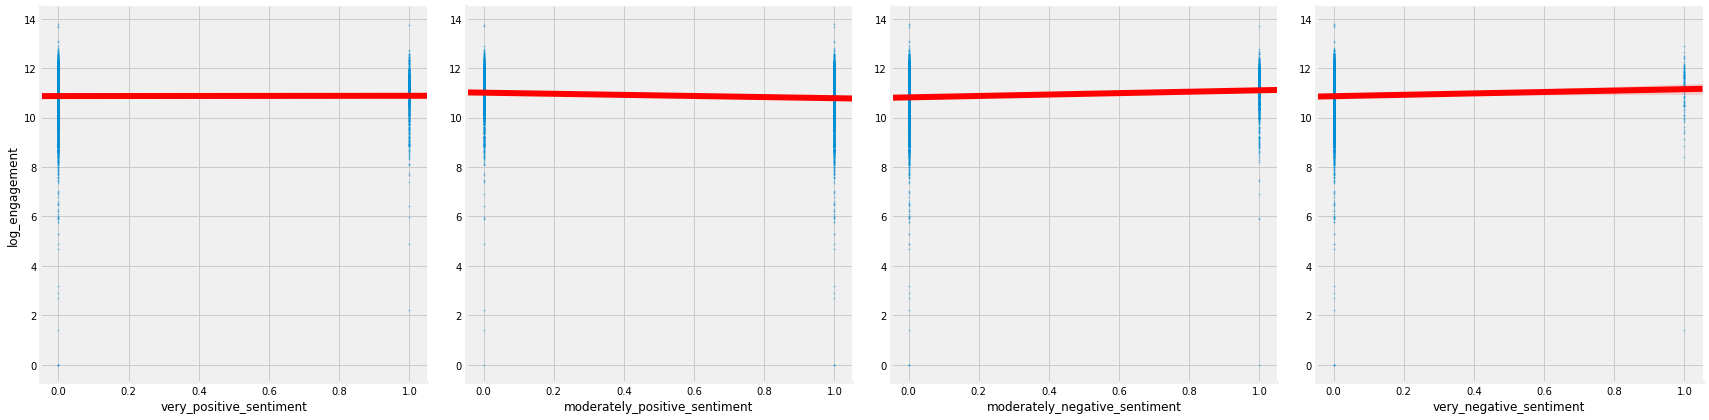

In [22]:
sns.pairplot(dummy_trumptweets,
            x_vars=['very_positive_sentiment', 'moderately_positive_sentiment', 'moderately_negative_sentiment',
                    'very_negative_sentiment'],
            y_vars='log_engagement',
            kind='reg',
            plot_kws={'scatter_kws': {'s':1, 'alpha':.3},
                      'line_kws': {'color':'red'}
                     },
            size=6
            );

**Testing Polynomial Features on Sentiment**

In [23]:
#Testing Polynomial Features on Sentiment

from sklearn.preprocessing import PolynomialFeatures

X = (dummy_trumptweets.loc[:, ['sentiment']])

pf = PolynomialFeatures(degree=1, include_bias=False)
pf.fit(X)
X = pf.transform(X)

y = dummy_trumptweets.loc[:, 'log_engagement']

In [24]:
lr = LinearRegression()
lr.fit(X, y)

y_fit = lr.predict(X)


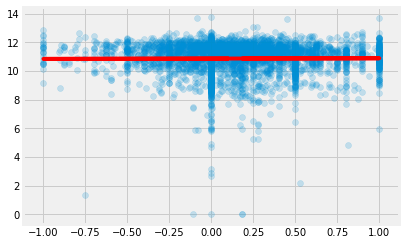

In [25]:
plt.plot(dummy_trumptweets.loc[:, 'sentiment'].values, y_fit, color='r')
plt.scatter(dummy_trumptweets.loc[:, 'sentiment'], y, alpha=.2)

**Testing Log features on Sentiment**

In [26]:
# Using 2 parameter Box-Cox transformation of log(x + 1.1) to transform all values greater than 0

dummy_trumptweets.loc[:, 'log_sentiment'] = np.log(dummy_trumptweets.loc[:, 'sentiment'] + 1.1)

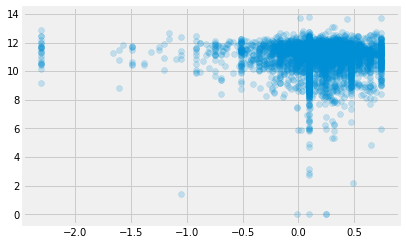

In [27]:
x =  dummy_trumptweets.loc[:, 'log_sentiment']
y = dummy_trumptweets.loc[:, 'log_engagement']
plt.scatter(x, y, alpha=.2)
plt.show()

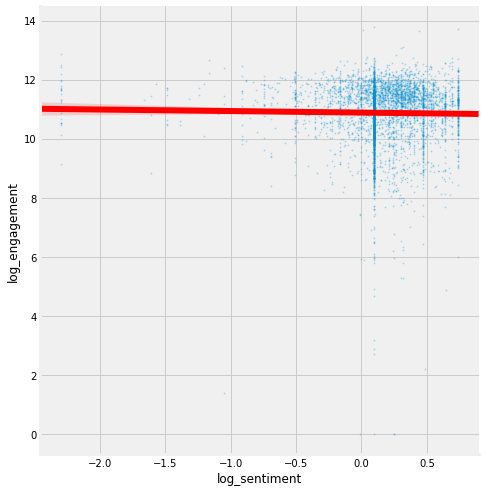

In [28]:
sns.pairplot(dummy_trumptweets,
            x_vars='log_sentiment',
            y_vars='log_engagement',
            kind='reg',
            plot_kws={'scatter_kws': {'s':1, 'alpha':.2},
                      'line_kws': {'color':'red'}
                     },
            size=7
            );

In [29]:
#review the tweets that are considered 'very negative'


very_positive_tweets = dummy_trumptweets.loc[dummy_trumptweets.loc[:, 'very_positive_sentiment'] == 1, :]
very_negative_tweets = dummy_trumptweets.loc[dummy_trumptweets.loc[:, 'very_negative_sentiment'] == 1, :]


In [30]:
very_negative_tweets.loc[:, ('text','engagement', 'sentiment', 'favorite_count', 'retweet_count')].sort_values('engagement', ascending=False)

text  \
created_at                                                               
2017-10-02 11:11:00  My warmest condolences and sympathies to the v...   
2017-02-01 12:50:00  Everybody is arguing whether or not it is a BA...   
2017-01-25 02:25:00  If Chicago doesn't fix the horrible "carnage" ...   
2017-01-22 12:47:00  Watched protests yesterday but was under the i...   
2017-02-03 23:08:00            We must keep "evil" out of our country!   
2017-02-07 12:11:00  I don't know Putin have no deals in Russia and...   
2017-01-30 13:31:00  If the ban were announced with a one week noti...   
2017-03-04 11:35:00  Terrible! Just found out that Obama had my "wi...   
2017-01-31 11:21:00  Nancy Pelosi and Fake Tears Chuck Schumer held...   
2017-02-04 20:44:00  What is our country coming to when a judge can...   
2017-02-12 11:34:00  The crackdown on illegal criminals is merely t...   
2017-12-29 13:16:00  The Democrats have been told and fully underst...   
2017-12-11 14:17:00  Another false story this time in the Failing @...   
2017-11-15 10:45:00  While in the Philippines I was forced to watch...   
2017-02-04 21:44:00  Because the ban was lifted by a judge many ver...   
2017-08-14 22:29:00  Made additional remarks on Charlottesville and...   
2017-02-02 11:34:00  Iran has been formally PUT ON NOTICE for firin...   
2017-10-19 11:17:00  Uranium deal to Russia with Clinton help and O...   
2017-01-26 11:04:00  Ungrateful TRAITOR Chelsea Manning who should ...   
2017-07-05 11:14:00  The United States made some of the worst Trade...   
2017-07-24 10:40:00  Drain the Swamp should be changed to Drain the...   
2017-02-16 14:39:00  The Democrats had to come up with a story as t...   
2017-06-27 12:47:00  So they caught Fake News CNN cold but what abo...   
2017-09-20 02:41:00  I was saddened to see how bad the ratings were...   
2017-07-10 10:40:00  James Comey leaked CLASSIFIED INFORMATION to t...   
2016-11-30 11:20:00  ISIS is taking credit for the terrible stabbin...   
2017-09-15 10:42:00  Another attack in London by a loser terrorist....   
2017-08-30 13:27:00  After reading the false reporting and even fer...   
2017-07-10 11:47:00  If Chelsea Clinton were asked to hold the seat...   
2017-01-29 13:00:00  Somebody with aptitude and conviction should b...   
...                                                                ...   
2017-11-07 10:53:00  ....and has been horrible on Virginia economy....   
2016-10-09 13:17:00  EXCLUSIVE  Video Interview: Bill Clinton Accu...   
2016-11-29 02:19:00  "@FiIibuster: @jeffzeleny Pathetic - you have ...   
2016-08-01 22:52:00  Hillary Clinton raked in money from regimes th...   
2016-10-05 01:28:00  "@Jnelson52722: @realDonaldTrump @Susiesentine...   
2016-10-08 22:41:00  RT @atensnut: Hillary calls Trump's remarks "h...   
2016-08-29 13:35:00  Now that African-Americans are seeing what a b...   
2016-08-05 13:08:00  Hillary Clinton has bad judgment and is unfit ...   
2016-08-29 22:03:00  We will repeal and replace the horrible disast...   
2016-09-17 22:57:00  My lawyers want to sue the failing @nytimes so...   
2016-09-27 01:33:00   HILLARY'S BAD TAX HABIT! https://t.co/x3FBy8Hdq2   
2016-07-25 11:57:00  How much BAD JUDGEMENT was on display by the p...   
2016-07-29 18:30:00  Even Bill is tired of the lies SAD! https://t....   
2016-10-28 15:27:00  "@Jmoschetti1363: @Johnatsrs1949 FBI must be o...   
2016-10-10 02:11:00  We cannot let this evil continue! #Debates2016...   
2016-10-09 22:26:00  The Palestinian terror attack today reminds th...   
2016-10-25 14:31:00  As election looms some bad news for Clinton De...   
2016-10-10 01:43:00  #CrookedHillary has FAILED all over the world!...   
2016-10-20 02:19:00  Bernie Sanders on HRC: Bad Judgement. John Pod...   
2016-10-20 01:28:00  Hillary is too weak to lead on border security...   
2016-10-20 01:37:00  .@HillaryClinton- you have failed failed and f...   
2016-09-27 01:23:00  .@HillaryClinton channels John Kerry on trade:...

In [31]:
very_positive_tweets.shape

(823, 25)

# Analysis and Visualizations

In [32]:
dummy_trumptweets.source.value_counts()

Twitter for iPhone     3341
Twitter for Android     861
Twitter Web Client      195
Media Studio            130
Twitter Ads              94
Twitter for iPad         51
TweetDeck                 2
Periscope                 1
Name: source, dtype: int64

In [33]:
#describe all

dummy_trumptweets.describe(include='all')

source                       text  retweet_count  \
count                 4675                       4675    4675.000000   
unique                   8                       4665            NaN   
top     Twitter for iPhone  MAKE AMERICA GREAT AGAIN!            NaN   
freq                  3341                          7            NaN   
mean                   NaN                        NaN   16402.736898   
std                    NaN                        NaN   13960.319769   
min                    NaN                        NaN       0.000000   
25%                    NaN                        NaN    8770.000000   
50%                    NaN                        NaN   13781.000000   
75%                    NaN                        NaN   20583.000000   
max                    NaN                        NaN  369530.000000   

        favorite_count is_retweet        id_str  src_android  src_webclient  \
count      4675.000000       4675  4.675000e+03  4675.000000    4675.000000   
unique             NaN          2           NaN          NaN            NaN   
top                NaN      False           NaN          NaN            NaN   
freq               NaN       4228           NaN          NaN            NaN   
mean      60308.453904        NaN  8.542120e+17     0.184171       0.041711   
std       48323.015209        NaN  6.611347e+16     0.387665       0.199950   
min           0.000000        NaN  7.549926e+17     0.000000       0.000000   
25%       23298.500000        NaN  7.889149e+17     0.000000       0.000000   
50%       55454.000000        NaN  8.569286e+17     0.000000       0.000000   
75%       86214.000000        NaN  9.131525e+17     0.000000       0.000000   
max      633253.000000        NaN  9.714098e+17     1.000000       1.000000   

        src_mediastudio  src_twitterads      ...        is_afternoon  \
count       4675.000000     4675.000000      ...         4675.000000   
unique              NaN             NaN      ...                 NaN   
top                 NaN             NaN      ...                 NaN   
freq                NaN             NaN      ...                 NaN   
mean           0.027807        0.020107      ...            0.278503   
std            0.164438        0.140381      ...            0.448310   
min            0.000000        0.000000      ...            0.000000   
25%            0.000000        0.000000      ...            0.000000   
50%            0.000000        0.000000      ...            0.000000   
75%            0.000000        0.000000      ...            1.000000   
max            1.000000        1.000000      ...            1.000000   

         is_evening  is_latenight  log_engagement    sentiment  \
count   4675.000000   4675.000000     4675.000000  4675.000000   
unique          NaN           NaN             NaN          NaN   
top             NaN           NaN             NaN          NaN   
freq            NaN           NaN             NaN          NaN   
mean       0.263529      0.019037       10.874569     0.143641   
std        0.440594      0.136671        1.084766     0.354736   
min        0.000000      0.000000        0.000000    -1.000000   
25%        0.000000      0.000000       10.389703     0.000000   
50%        0.000000      0.000000       11.133435     0.008333   
75%        1.000000      0.000000       11.571878     0.350000   
max        1.000000      1.000000       13.789811     1.000000   

        very_positive_sentiment  moderately_positive_sentiment  \
count               4675.000000                    4675.000000   
unique                      NaN                            NaN   
top                         NaN                            NaN   
freq                        NaN                            NaN   
mean                   0.176043                       0.606203   
std                    0.380897                       0.488643   
min                    0.000000                       0.000000   
25%                 

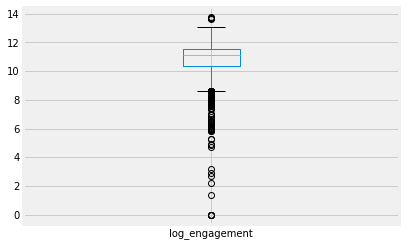

In [34]:
#boxplot of log(engagement)

dummy_trumptweets.loc[:,'log_engagement'].plot(kind='box')

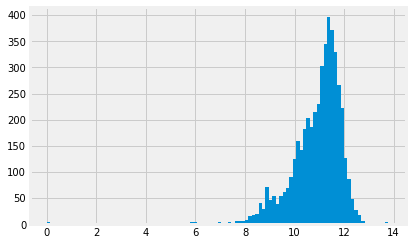

In [35]:
#Histogram of log(engagement)

dummy_trumptweets.loc[:, 'log_engagement'].hist(bins=100)

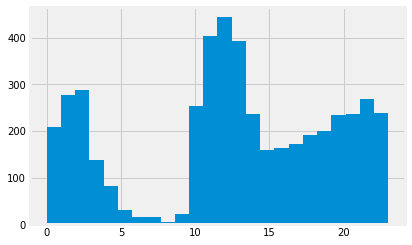

In [36]:
#Histogram of tweet_hour 

dummy_trumptweets.loc[:, 'tweet_hour'].hist(bins=24)

In [37]:
dummy_trumptweets.columns

Index(['source', 'text', 'retweet_count', 'favorite_count', 'is_retweet',
       'id_str', 'src_android', 'src_webclient', 'src_mediastudio',
       'src_twitterads', 'src_ipad', 'src_tweetdeck', 'src_periscope',
       'engagement', 'tweet_hour', 'is_afternoon', 'is_evening',
       'is_latenight', 'log_engagement', 'sentiment',
       'very_positive_sentiment', 'moderately_positive_sentiment',
       'moderately_negative_sentiment', 'very_negative_sentiment',
       'log_sentiment'],
      dtype='object')

In [38]:
feature_cols = ['is_retweet', 
                'is_afternoon', 
                'is_evening', 
                'is_latenight', 
                'moderately_positive_sentiment',
                'moderately_negative_sentiment', 
                'very_negative_sentiment']

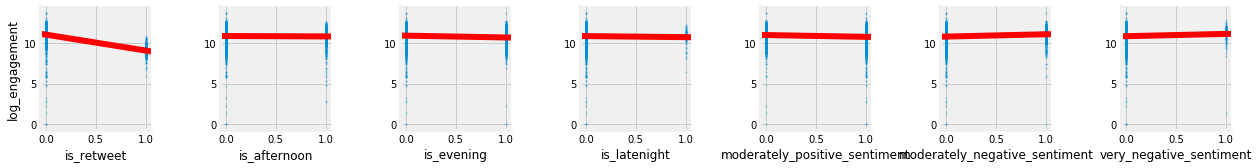

In [39]:
sns.pairplot(dummy_trumptweets,
            x_vars=feature_cols,
            y_vars='log_engagement',
            kind='reg',
            plot_kws={'scatter_kws': {'s':1, 'alpha':.3},
                      'line_kws': {'color':'red'}
                     }
            );

In [40]:
# Embiggen the negative sentiment charts



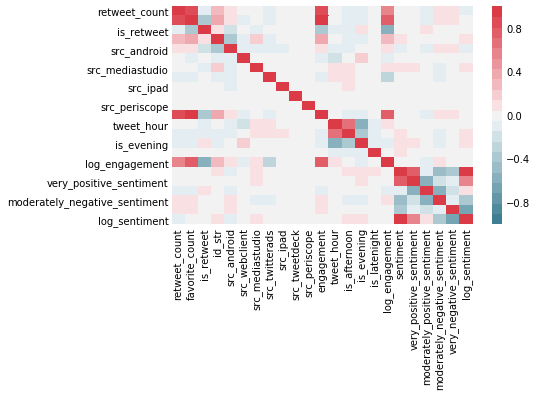

In [41]:
#Insert Correlation Matrix with HeatMap

sns.heatmap(dummy_trumptweets.corr(),
            vmin=-1,
            vmax = 1,
            cmap = sns.diverging_palette(220, 10, n=21),
            );

is_retweet


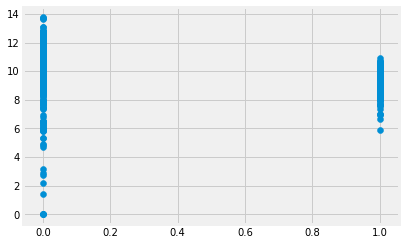

is_afternoon


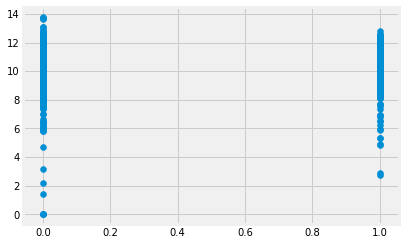

is_evening


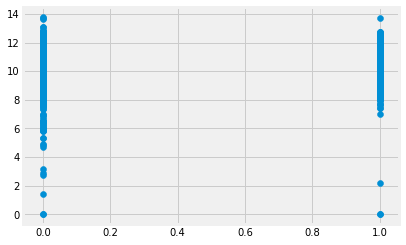

is_latenight


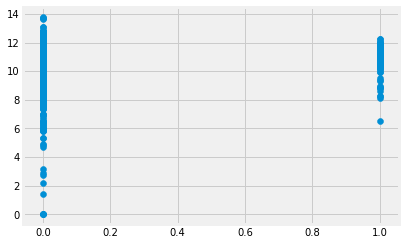

moderately_positive_sentiment


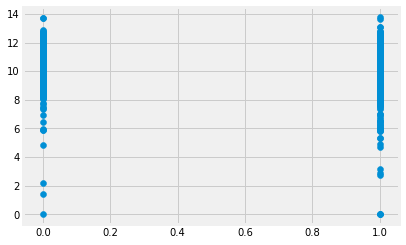

moderately_negative_sentiment


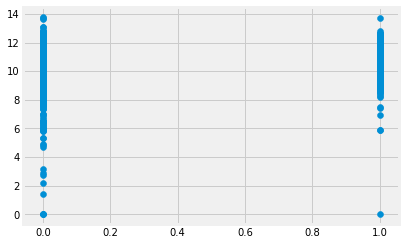

very_negative_sentiment


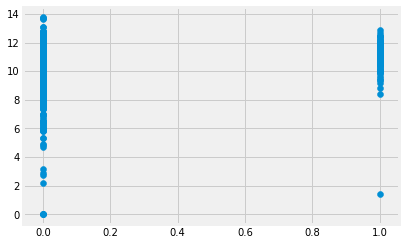

In [42]:
#Review Scatter Plots

y = dummy_trumptweets.loc[:, 'log_engagement']

for var in feature_cols:
    print(var)
    x = dummy_trumptweets.loc[:, var]
    plt.scatter(x, y)
    plt.show()

# Linear Regression

In [43]:
X = dummy_trumptweets.loc[:, feature_cols]
y = dummy_trumptweets.loc[:, 'log_engagement']


In [44]:
#Split Train and Test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [45]:
from sklearn.model_selection import cross_val_score, KFold

In [46]:
# K-Folds cross Validation

kf = KFold(n_splits=5, shuffle=True)

mse_score = np.mean(-cross_val_score(lr, X, y, cv=kf,  scoring='neg_mean_squared_error'))
rmse_score = np.sqrt(mse_score)

print('KFolds Cross Validation MSE:', mse_score)
print('KFolds Cross Validation RMSE:', rmse_score)


KFolds Cross Validation MSE: 0.82134084302
KFolds Cross Validation RMSE: 0.906278568112


In [47]:
# compare predicted results against the test set

#print(metrics.mean_squared_error(y_train, lr.predict(X_train)))

print('MAE', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE 0.582941962099
MSE: 0.81435367821
RMSE 0.902415468734


In [48]:
#Create Benchmark of Mean Values

y_pred_null = np.ones(y_test.shape) * y_train.mean()

#compare y_test against the y_means
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_null))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_null))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_null)))

MAE: 0.77675801189
MSE: 1.18271150796
RMSE: 1.08752540566


In [49]:
print(lr.intercept_)
list(zip(feature_cols, lr.coef_))

11.226384712


[('is_retweet', -1.9723231667816823),
 ('is_afternoon', -0.25955238235624056),
 ('is_evening', -0.2449081594128541),
 ('is_latenight', -0.28486298137427551),
 ('moderately_positive_sentiment', -0.082101692304176577),
 ('moderately_negative_sentiment', 0.10024364878648255),
 ('very_negative_sentiment', 0.22730541657740816)]

In [59]:
# Testing Polynomial Features on a smaller model

feature_cols = ['is_retweet',
                'moderately_positive_sentiment',
                'moderately_negative_sentiment', 
                'very_negative_sentiment']

X = dummy_trumptweets.loc[:, feature_cols]
y = dummy_trumptweets.loc[:, 'log_engagement']


In [58]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True)

for poly_degree in range(1,11):
    pf = PolynomialFeatures(degree=poly_degree, include_bias=False)
    pf.fit(X)
    X_poly = pf.transform(X)

    lr = LinearRegression()
    score = np.mean(-cross_val_score(lr, X_poly, y, cv=kf, 
                                     scoring='neg_mean_squared_error'))
    print(poly_degree, score)


1 0.833381503711
2 0.835501069099
3 0.834461253269
4 0.833928027878
5 0.835032697223
6 0.836073210507
7 0.834328008093
8 0.835439706944
9 0.834625930356
10 0.836614721026


In [68]:
# Testing Polynomial Features on a smaller model with Log Sentiment

feature_cols = ['is_retweet',
                'log_sentiment']

X = dummy_trumptweets.loc[:, feature_cols]
y = dummy_trumptweets.loc[:, 'log_engagement']

In [69]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True)

for poly_degree in range(1,11):
    pf = PolynomialFeatures(degree=poly_degree, include_bias=False)
    pf.fit(X)
    X_poly = pf.transform(X)

    lr = LinearRegression()
    score = np.mean(-cross_val_score(lr, X_poly, y, cv=kf, 
                                     scoring='neg_mean_squared_error'))
    print(poly_degree, score)



1 0.84037102548
2 0.839377703564
3 0.839380879312
4 0.840224088683
5 0.840648551634
6 0.836847867665
7 0.841326555436
8 2.05158317513
9 42.9815706233
10 821084.629234


In [61]:
#Interaction Terms

In [115]:
dummy_trumptweets.columns

Index(['source', 'text', 'retweet_count', 'favorite_count', 'is_retweet',
       'id_str', 'src_android', 'src_webclient', 'src_mediastudio',
       'src_twitterads', 'src_ipad', 'src_tweetdeck', 'src_periscope',
       'engagement', 'tweet_hour', 'is_afternoon', 'is_evening',
       'is_latenight', 'log_engagement', 'sentiment',
       'very_positive_sentiment', 'moderately_positive_sentiment',
       'moderately_negative_sentiment', 'very_negative_sentiment',
       'log_sentiment'],
      dtype='object')

In [128]:
# Regularization with Lasso

feature_cols = ['is_retweet',
                'moderately_positive_sentiment',
                'moderately_negative_sentiment', 
                'very_negative_sentiment',
                'src_android', 
                'src_webclient', 
                'src_mediastudio',
                'src_twitterads', 
                'src_ipad', 
                'src_tweetdeck', 
                'src_periscope',
                'is_afternoon', 
                'is_evening',
                'is_latenight'
               ]

X = dummy_trumptweets.loc[:, feature_cols]
y = dummy_trumptweets.loc[:, 'log_engagement']


In [129]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [134]:
from sklearn.linear_model import Lasso

lassoreg = Lasso(alpha=.001, normalize=True)
lassoreg.fit(X_train, y_train)
y_pred = lassoreg.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.86518095523326666

In [135]:
list(zip(feature_cols, lassoreg.coef_))

[('is_retweet', -1.7979719903772711),
 ('moderately_positive_sentiment', -0.0049666128093574478),
 ('moderately_negative_sentiment', 0.014405560279541265),
 ('very_negative_sentiment', 0.0),
 ('src_android', -0.0),
 ('src_webclient', -0.23403958372144415),
 ('src_mediastudio', 0.0),
 ('src_twitterads', -1.7599166198186638),
 ('src_ipad', -0.0),
 ('src_tweetdeck', -0.0),
 ('src_periscope', -0.0),
 ('is_afternoon', -0.0),
 ('is_evening', -0.015865848533840644),
 ('is_latenight', -0.0)]

In [150]:
#Regularized Model

feature_cols = ['is_retweet',
                'moderately_positive_sentiment',
                'moderately_negative_sentiment', 
                'very_negative_sentiment',
                'src_webclient', 
                'src_twitterads', 
                'is_evening',
               ]

X = dummy_trumptweets.loc[:, feature_cols]
y = dummy_trumptweets.loc[:, 'log_engagement']

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

y_pred = lr_reg.predict(X_test)

np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.86110356277443412

# Conclusion




dig into the #hashtags

In [ ]:
#run metrics on both the test and train set